False
[[[ 441 1724  442 1799]]

 [[ 453 2471  454 2527]]

 [[ 460 3545  461 3599]]

 ...

 [[ 477 3836  482 3907]]

 [[1631 2165 1689 2164]]

 [[2105 3054 2121 3107]]]
807


KeyboardInterrupt: 

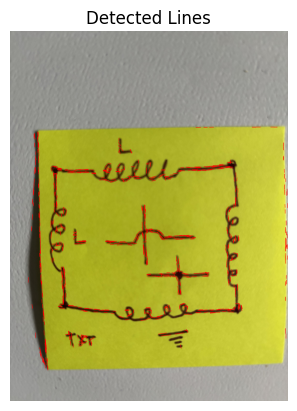

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from nodes import merge_lines, unnest_list

image = cv2.imread("test3.jpg")
print(image is None)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edges = cv2.Canny(blurred, threshold1=20, threshold2=25, apertureSize=3)
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=25, minLineLength=50, maxLineGap=10)
print(lines)
print(len(lines))
line_image = image.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 5)

plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")
plt.axis("off")
plt.show

lst = unnest_list(lines)
lst = merge_lines(lst, angle_threshold=15, distance_threshold=25)
print(lst)
print(len(lst))


251


<function matplotlib.pyplot.show(close=None, block=None)>

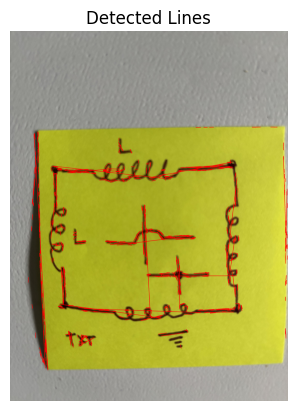

In [27]:

print(len(lst))
if lst is not None:
    for line in lst:
        x1, y1, x2, y2 = line
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 5)

plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")
plt.axis("off")
plt.show

90
[array([555,  18], dtype=int32), array([552,  11], dtype=int32), array([551,  11], dtype=int32), array([543,  14], dtype=int32)]
[array([357, 456], dtype=int32), array([361, 458], dtype=int32), array([362, 467], dtype=int32)]


<function matplotlib.pyplot.show(close=None, block=None)>

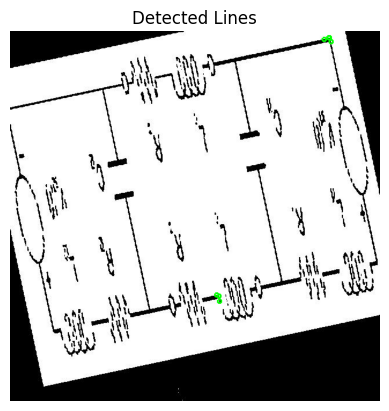

In [32]:
# lets cluster the points and check for intersection --> I will do this very simply at first as POC
# and then see if I can find a better algorithm that keeps a moving average cluster center. 
threshold = 10
clusters = []
for line in lines:
    x0, y0, x1, y1 = line[0]
    pt1, pt2 = np.array([x0, y0]), np.array([x1, y1])
    added1 = False
    added2 = False
    for cluster in clusters:

        if any(np.linalg.norm(pt1 - cpt) < threshold for cpt in cluster):
            cluster.append(pt1)
            added1 = True
            break

        if any(np.linalg.norm(pt2 - cpt) < threshold for cpt in cluster):
            cluster.append(pt2)
            added2 = True
            break

    if not added1:
        clusters.append([pt1])
    if not added2:
        clusters.append([pt2])

clust_image = image.copy()

print(len(clusters))
for clust in clusters:
    if len(clust) >= 3:
        print(clust)
        for pt in clust:
            x, y = pt
            cv2.circle(clust_image, (x, y), 3, (0, 255, 0), 2)


plt.imshow(cv2.cvtColor(clust_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")
plt.axis("off")
plt.show

    

In [22]:

# OK NEW APPROACH: CONTOUR MAPPING:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from nodes import merge_lines, unnest_list

from skimage.morphology import skeletonize


image = cv2.imread("test3.jpg")
image_fresh = image.copy

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
thresh = cv2.adaptiveThreshold(blurred, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

skeleton = skeletonize(closed // 255)


[(np.int64(128), np.int64(1)), (np.int64(129), np.int64(1)), (np.int64(3425), np.int64(1)), (np.int64(128), np.int64(2)), (np.int64(729), np.int64(2)), (np.int64(2135), np.int64(2)), (np.int64(2136), np.int64(2)), (np.int64(2299), np.int64(2)), (np.int64(3424), np.int64(2)), (np.int64(3425), np.int64(2)), (np.int64(728), np.int64(3)), (np.int64(729), np.int64(3)), (np.int64(1622), np.int64(3)), (np.int64(1623), np.int64(3)), (np.int64(2864), np.int64(3)), (np.int64(2865), np.int64(3)), (np.int64(3425), np.int64(3)), (np.int64(3883), np.int64(3)), (np.int64(85), np.int64(4)), (np.int64(729), np.int64(4)), (np.int64(1057), np.int64(4)), (np.int64(1623), np.int64(4)), (np.int64(2865), np.int64(4)), (np.int64(2908), np.int64(4)), (np.int64(3883), np.int64(4)), (np.int64(3884), np.int64(4)), (np.int64(3897), np.int64(4)), (np.int64(4250), np.int64(4)), (np.int64(4251), np.int64(4)), (np.int64(4252), np.int64(4)), (np.int64(29), np.int64(5)), (np.int64(30), np.int64(5)), (np.int64(84), np.in

<function matplotlib.pyplot.show(close=None, block=None)>

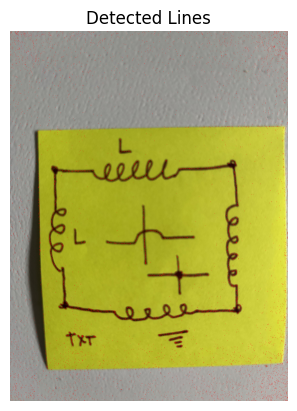

In [25]:
# continue pasting ngl


def find_junctions(skeleton: np.ndarray) -> list[tuple[int, int]]:
    """
    Find junctions in a 1-pixel-wide skeleton image.
    A junction is defined as a pixel with >= 3 connected neighbors.
    """
    points = np.argwhere(skeleton == 1)
    junctions = []

    for y, x in points:
        # avoid edges
        if 1 <= y < skeleton.shape[0] - 1 and 1 <= x < skeleton.shape[1] - 1:
            neighborhood = skeleton[y-1:y+2, x-1:x+2]
            if np.sum(neighborhood) - 1 >= 3:
                junctions.append((x, y))

    return junctions

junction_points = find_junctions(skeleton)

print(junction_points)
print(len(junction_points))

image3 = cv2.imread("test3.jpg")

for x, y in junction_points:
    cv2.circle(image, (x, y), 2, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")
plt.axis("off")
plt.show

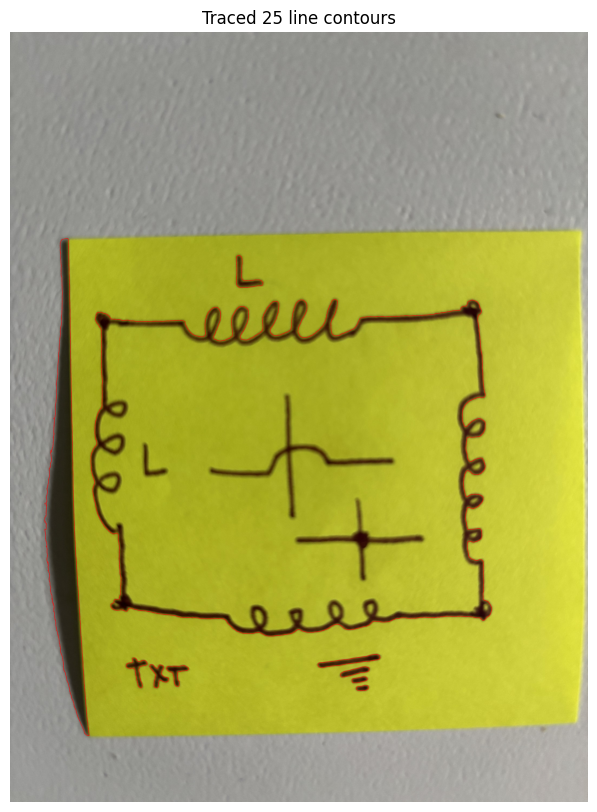

In [23]:
# ight lets try one more time:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def trace_lines_with_contours(image: np.ndarray):
    """
    Detects and traces lines in the input image using contours,
    then draws the contours with matplotlib.

    Args:
        image: Input BGR image (numpy array).

    Returns:
        contours: List of contours, each is a numpy array of points.
    """

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Binarize and invert so lines are white on black background
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological close to close small gaps in lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Find contours - external contours, keep all points
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Prepare image for drawing contours (convert BGR to RGB for matplotlib)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw contours on the image
    cv2.drawContours(img_rgb, contours, -1, (255, 0, 0), 2)  # Blue contours

    # Plot with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(f"Traced {len(contours)} line contours")
    plt.axis('off')
    plt.show()

    return contours

image = cv2.imread("test3.jpg")
contours = trace_lines_with_contours(image)

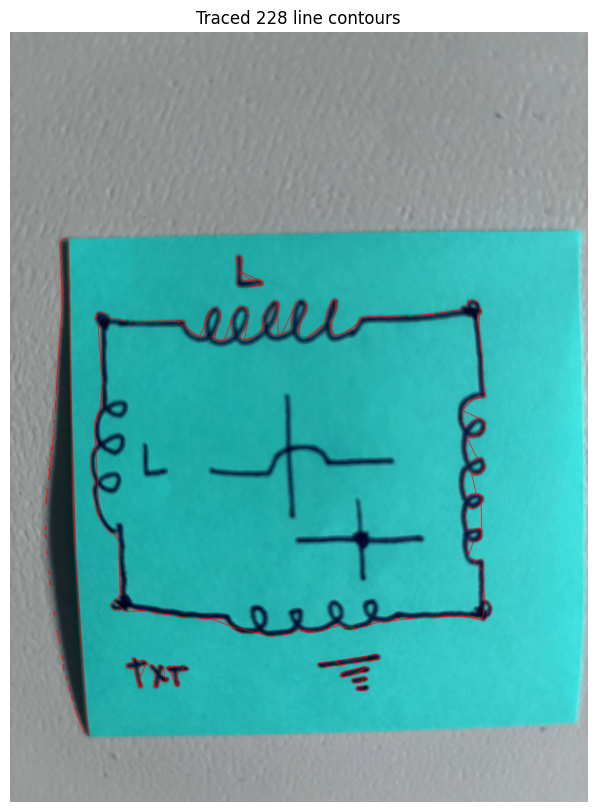

In [34]:
def local_straightness(contour, window_size=5):
    """
    Compute local straightness along contour using sliding window.

    Returns:
        List of straightness scores per window center point.
    """
    pts = contour[:, 0, :]
    n = len(pts)
    scores = []

    half_w = window_size // 2

    for i in range(n):
        start_idx = max(i - half_w, 0)
        end_idx = min(i + half_w + 1, n)
        segment = pts[start_idx:end_idx]

        # Compute chord length
        chord_len = np.linalg.norm(segment[-1] - segment[0])
        # Compute contour length
        diffs = np.diff(segment, axis=0)
        contour_len = np.sum(np.linalg.norm(diffs, axis=1))

        score = chord_len / contour_len if contour_len > 0 else 0
        scores.append(score)

    return scores


def contour_geometric_length(contour):
    pts = contour[:, 0, :]  # Extract points, shape (N,2)
    diffs = np.diff(pts, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    return np.sum(segment_lengths)

def split_contour_by_straightness(contour, threshold=0.9, window_size=5, min_length=10):
    scores = local_straightness(contour, window_size)
    break_points = [0]

    for i in range(1, len(scores)):
        if scores[i] < threshold and scores[i-1] >= threshold:
            break_points.append(i)
        elif scores[i] >= threshold and scores[i-1] < threshold:
            break_points.append(i)

    break_points.append(len(contour))
    break_points = sorted(set(break_points))

    segments = []
    for i in range(len(break_points)-1):
        start, end = break_points[i], break_points[i+1]
        segment = contour[start:end]
        length = contour_geometric_length(segment)
        if length >= min_length:
            segments.append(segment)

    return segments

cont_new = []
for contour in contours:
    cont_new.append(split_contour_by_straightness(contour, window_size=5, min_length=25, threshold=0.8))

image4 = cv2.imread("test3.jpg")

total = 0
for segment in cont_new:
    cv2.drawContours(image4, segment, -1, (255, 0, 0), 4)  # Blue contours
    total += len(segment)
# Plot with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image4)
plt.title(f"Traced {total} line contours")
plt.axis('off')
plt.show()